In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [9]:
df = pd.read_csv('/content/fake_or_real_news_cleaned.csv')
df.head()
df['label'].value_counts()

,count
label,
0,23481
1,21417


In [10]:
# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])  # fake=0, real=1

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['title'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [11]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,692,097 (10.27 MB)

 Trainable params: 2,692,097 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train_tfidf.toarray(), y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.8545 - loss: 0.3034 - val_accuracy: 0.9471 - val_loss: 0.1344
Epoch 2/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.9654 - loss: 0.0957 - val_accuracy: 0.9504 - val_loss: 0.1328
Epoch 3/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.9790 - loss: 0.0566 - val_accuracy: 0.9496 - val_loss: 0.1505
Epoch 4/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.9906 - loss: 0.0279 - val_accuracy: 0.9474 - val_loss: 0.1891
Epoch 5/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.9959 - loss: 0.0112 - val_accuracy: 0.9499 - val_loss: 0.2334
Epoch 6/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.9985 - loss: 0.0049 - val_accuracy: 0.9488 - val_loss: 0.2812
Epoch 7/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.9983 - loss: 0.0048 - val_accuracy: 0.9482 - val_loss: 0.3423
Epoch 8/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.9988 -

In [13]:
y_pred = (model.predict(X_test_tfidf.toarray()) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))


281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Accuracy: 0.9433184855233853
              precision    recall  f1-score   support

        Fake       0.94      0.95      0.95      4696
        Real       0.94      0.94      0.94      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



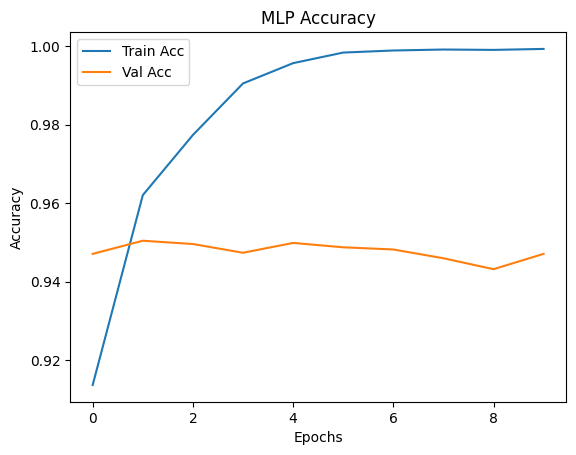

In [14]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('MLP Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
